## Source: https://www.tensorflow.org/tutorials/images/classification

In [1]:
import tensorflow as tf
from matplotlib import pyplot
import numpy as np
import os
import json

In [2]:
train_ds = tf.keras.utils.image_dataset_from_directory("data",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(50, 50),
  batch_size=32)

Found 39698 files belonging to 4 classes.
Using 31759 files for training.


In [3]:
val_ds = tf.keras.utils.image_dataset_from_directory("data",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(50, 50),
  batch_size=32)

Found 39698 files belonging to 4 classes.
Using 7939 files for validation.


In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [6]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(50,50,3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
    tf.keras.layers.RandomCrop(45, 45) #height, width
  ]
)

In [7]:
num_classes = 4
models = {}

In [8]:
models["CNN"] = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.Rescaling(1./255, input_shape=(50, 50, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [9]:
models["MLP"] = tf.keras.Sequential([
    data_augmentation,
    tf.keras.layers.Flatten(input_shape=(50, 50, 3)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [10]:
for model in models.values():
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
for model in models.values():
    model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 45, 45, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (None, 45, 45, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 45, 45, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 32)       0         
 2D)                                                  

In [12]:
epochs=2
histories = {}

In [13]:
for name in models:
    print("Training "+name)
    model_path = os.path.join("saved_models/", name+".h5")
    history_path = os.path.join("saved_histories", name+".json")
    histories[name] = models[name].fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
    )
    models[name].save(model_path)
    json.dump(histories[name].history, open(history_path, 'w'))

Training CNN
Epoch 1/2
993/993 [==============================] - 20s 9ms/step - loss: 0.9337 - accuracy: 0.5812 - val_loss: 0.6962 - val_accuracy: 0.7136
Epoch 2/2
993/993 [==============================] - 8s 8ms/step - loss: 0.6535 - accuracy: 0.7363 - val_loss: 0.5928 - val_accuracy: 0.7701
Training MLP
Epoch 1/2
993/993 [==============================] - 7s 6ms/step - loss: 211.4147 - accuracy: 0.3448 - val_loss: 262.7226 - val_accuracy: 0.2752
Epoch 2/2
993/993 [==============================] - 6s 6ms/step - loss: 87.7381 - accuracy: 0.3574 - val_loss: 49.1132 - val_accuracy: 0.3148


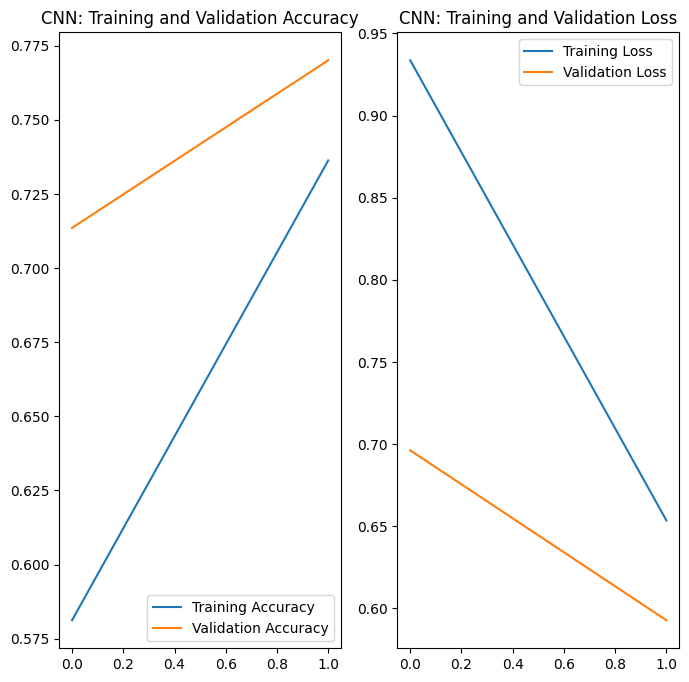

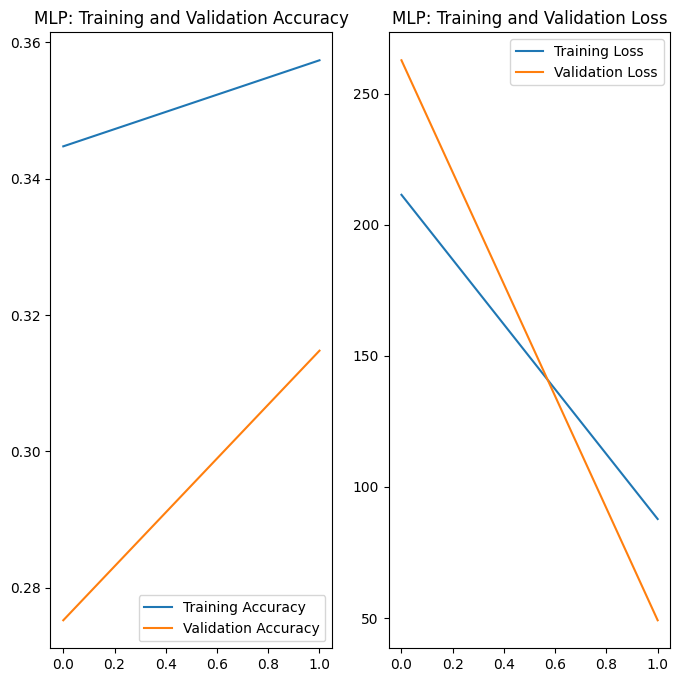

In [14]:
for name in histories:
    history = histories[name]
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    pyplot.figure(figsize=(8, 8))
    pyplot.subplot(1, 2, 1)
    pyplot.plot(epochs_range, acc, label='Training Accuracy')
    pyplot.plot(epochs_range, val_acc, label='Validation Accuracy')
    pyplot.legend(loc='lower right')
    pyplot.title(name+': Training and Validation Accuracy')

    pyplot.subplot(1, 2, 2)
    pyplot.plot(epochs_range, loss, label='Training Loss')
    pyplot.plot(epochs_range, val_loss, label='Validation Loss')
    pyplot.legend(loc='upper right')
    pyplot.title(name+': Training and Validation Loss')
    pyplot.show()

In [15]:
class_names = ["Access Granted","Access Denied - Please wear a mask over your nose.", "Access Denied - Please wear a mask over your mouth and nose.","Access Denied - Please wear a mask"]

In [16]:
def predict(file_path):
    
    img = tf.keras.utils.load_img(file_path, target_size=(50, 50))
    pyplot.imshow(img)

    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    
    for name in models:
        model = models[name]
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])


        print(
            "{} predicts {} ({:.2f}% confidence)"
            .format(name, class_names[np.argmax(score)], 100 * np.max(score))
        )
    pyplot.show()
        


CNN predicts Access Denied - Please wear a mask (64.11% confidence)
MLP predicts Access Granted (100.00% confidence)


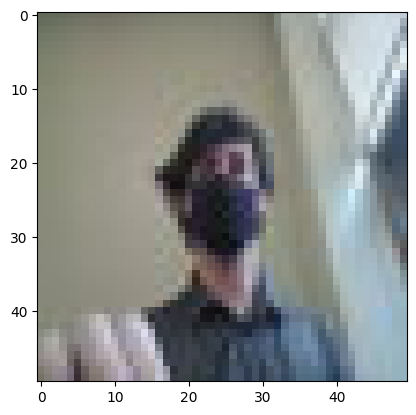

In [17]:
predict("faces/benjamin/1.jpg")

CNN predicts Access Denied - Please wear a mask (57.15% confidence)
MLP predicts Access Granted (100.00% confidence)


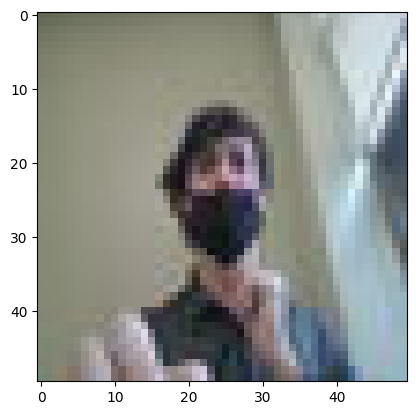

In [18]:
predict("faces/benjamin/2.jpg")

CNN predicts Access Denied - Please wear a mask (71.34% confidence)
MLP predicts Access Granted (100.00% confidence)


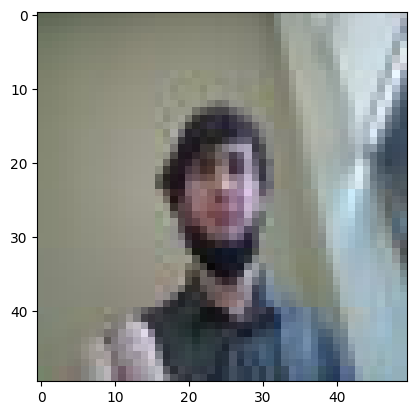

In [19]:
predict("faces/benjamin/3.jpg")

CNN predicts Access Denied - Please wear a mask (69.31% confidence)
MLP predicts Access Granted (100.00% confidence)


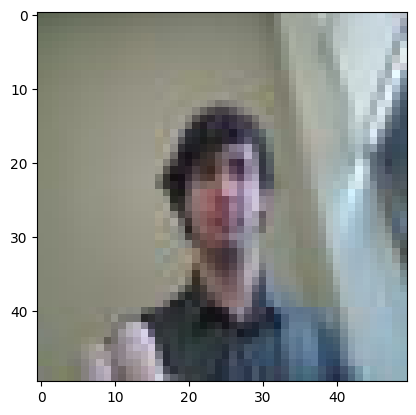

In [20]:
predict("faces/benjamin/4.jpg")

CNN predicts Access Denied - Please wear a mask (42.81% confidence)
MLP predicts Access Granted (100.00% confidence)


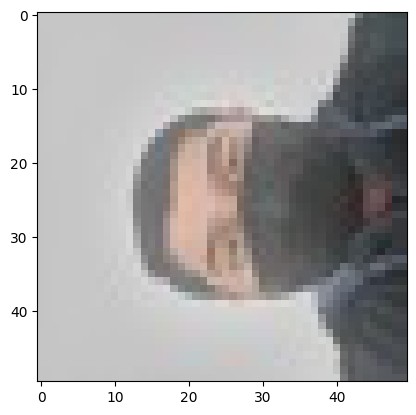

In [21]:
predict("faces/shaurya/1.jpg")

CNN predicts Access Denied - Please wear a mask (61.78% confidence)
MLP predicts Access Granted (100.00% confidence)


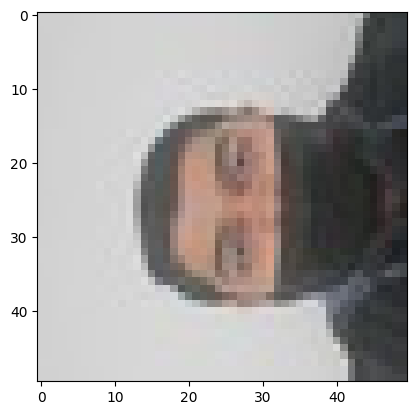

In [22]:
predict("faces/shaurya/2.jpg")

CNN predicts Access Denied - Please wear a mask (61.72% confidence)
MLP predicts Access Granted (100.00% confidence)


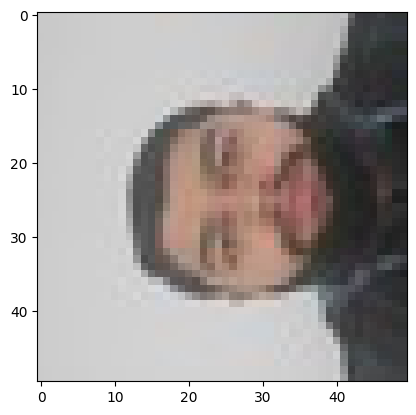

In [23]:
predict("faces/shaurya/3.jpg")

CNN predicts Access Denied - Please wear a mask (49.95% confidence)
MLP predicts Access Granted (100.00% confidence)


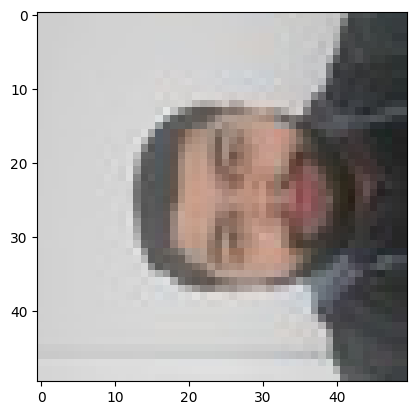

In [24]:
predict("faces/shaurya/4.jpg")

CNN predicts Access Granted (98.51% confidence)
MLP predicts Access Granted (100.00% confidence)


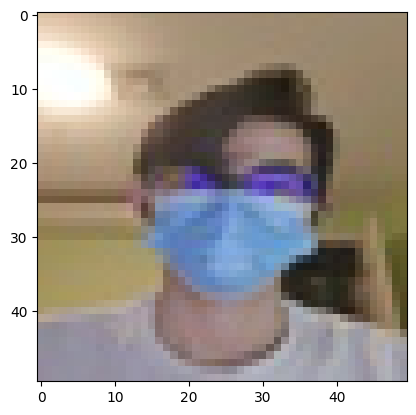

In [25]:
predict("faces/zunyi/1.jpg")

CNN predicts Access Denied - Please wear a mask over your nose. (87.04% confidence)
MLP predicts Access Granted (100.00% confidence)


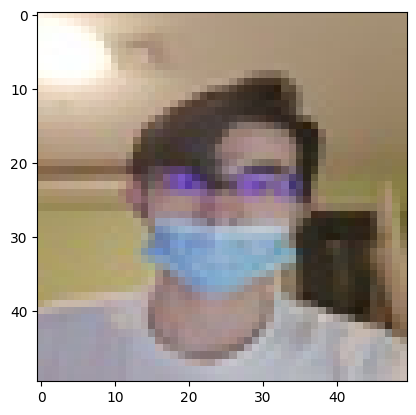

In [26]:
predict("faces/zunyi/2.jpg")

CNN predicts Access Denied - Please wear a mask over your mouth and nose. (99.67% confidence)
MLP predicts Access Granted (100.00% confidence)


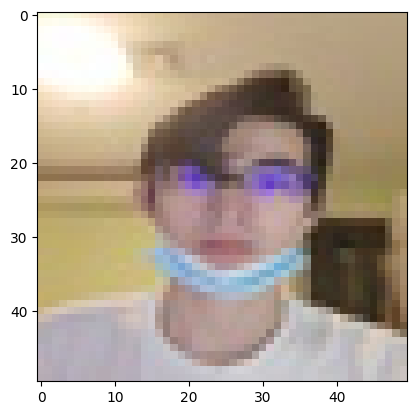

In [27]:
predict("faces/zunyi/3.jpg")

CNN predicts Access Denied - Please wear a mask (86.80% confidence)
MLP predicts Access Granted (100.00% confidence)


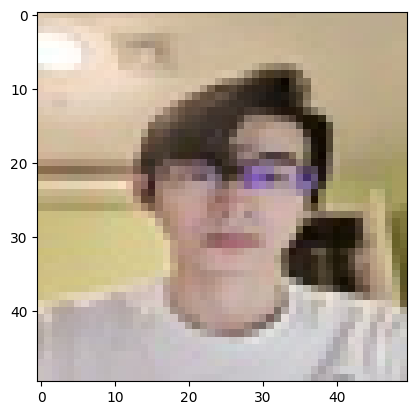

In [28]:
predict("faces/zunyi/4.jpg")

CNN predicts Access Denied - Please wear a mask (90.88% confidence)
MLP predicts Access Granted (100.00% confidence)


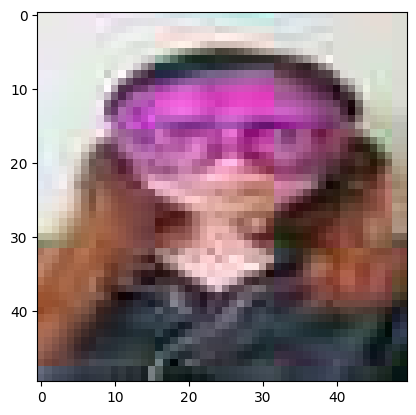

In [29]:
predict("faces/parisa/1.jpg")

CNN predicts Access Denied - Please wear a mask (85.41% confidence)
MLP predicts Access Granted (100.00% confidence)


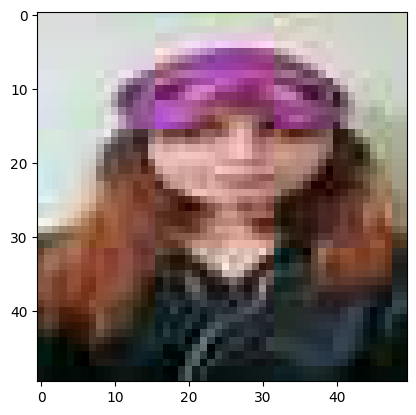

In [30]:
predict("faces/parisa/2.jpg")

CNN predicts Access Denied - Please wear a mask (97.71% confidence)
MLP predicts Access Granted (100.00% confidence)


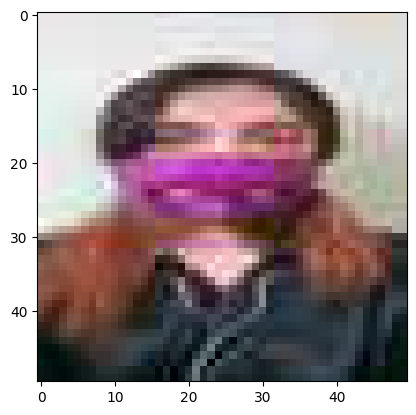

In [31]:
predict("faces/parisa/3.jpg")